In [58]:
import numpy as np
import matplotlib.pyplot as plt
from libs.XY_model import XYSystem
import cv2

In [41]:
xy1 = XYSystem(temperature = 0.5, width = 10)

#sweeps=1
energy=-0.52


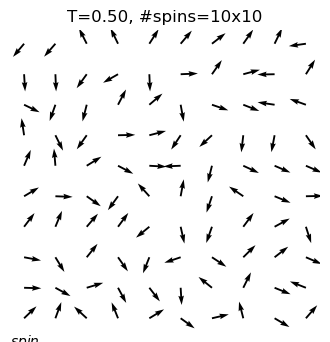


equilibrium state is reached at T=0.5
#sweep=770
energy=-1.70


In [43]:
xy1.equilibrate(show=True)

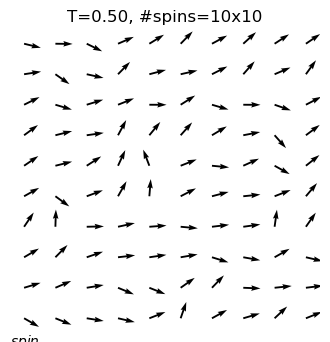

In [44]:
xy1.show()

In [48]:
x = np.reshape(xy1.spin_config, (-1, 10))

In [52]:
bin_img = np.zeros([10, 10]) + 255

In [55]:
for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        if(abs(x[(i+1)%x.shape[0], j] - x[i, j]) < 1 or abs(x[i, j] - x[abs(i-1)%x.shape[0], j]) < 1 or
           abs(x[i, (j+1)%x.shape[1]] - x[i, j]) < 1 or abs(x[i, abs(j-1)%x.shape[1]] - x[i, j]) < 1):
            bin_img[i, j] = 0

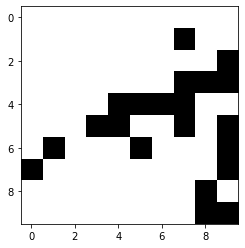

In [56]:
plt.imshow(bin_img, cmap='Greys');